In [1]:
import os
import gc
import logging
import multiprocessing
n_cores = multiprocessing.cpu_count()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"
#os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
#os.environ["TF_GPU_THREAD_COUNT"] = str(n_cores)
logger = logging.getLogger()
logger.setLevel(logging.WARN)
import time
import numpy as np
import tensorflow as tf
#tf.config.threading.set_inter_op_parallelism_threads(n_cores)
import tensorflow_datasets as tfds
import cnn_models
import utils
from nvstatsrecorder.callbacks import NVStats

def reset_session():
    try:
        del model
        del strategy
        del dataset
        del train
    except:
        pass
    gc.collect()
    tf.keras.backend.clear_session()
    tf.config.optimizer.set_jit(True)
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

reset_session()
strategy = tf.distribute.MirroredStrategy()
replicas = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [2]:
LEARNING_RATE = 0.001 * replicas
BATCH_SIZE = 256 * replicas
IMG_SIZE = (224, 224)
CROP_IMGSIZE = (224, 224, 3)
LARGER_IMGSIZE = (int(224*1.1), int(224*1.1))

print("Number of devices:", replicas)
print("Global batch size:", BATCH_SIZE)

Number of devices: 4
Global batch size: 1024


# Default - Slow!

In [3]:
dataset_name = "imagenet2012"
dataset, info = tfds.load(dataset_name,
                          with_info=True,
                          as_supervised=True)

num_class = info.features["label"].num_classes
num_train = info.splits["train"].num_examples
num_valid = info.splits["validation"].num_examples

print(dataset_name+":", num_class, "classes")
print("Train examples:", num_train)
print("Valid examples:", num_valid)

@tf.function
def format_train_example(_image, _label):
    image = tf.image.resize(_image, LARGER_IMGSIZE)
    image = tf.image.random_crop(image, CROP_IMGSIZE)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(_label, num_class)
    return image, label

train = dataset["train"]
train = train.shuffle(16384)
train = train.repeat(count=-1)
train = train.map(format_train_example, num_parallel_calls=n_cores)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(50)

print("Running pipeline:")
for batch in train.take(2):
    test_img = batch[0].numpy()
    label = batch[1].numpy()
    print("* Image shape:", test_img.shape)
    print("* Label shape:", label.shape)
    
# let prefetch finish
time.sleep(2)

imagenet2012: 1000 classes
Train examples: 1281167
Valid examples: 50000
Running pipeline:
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024, 1000)
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024, 1000)


In [4]:
with strategy.scope():
    model = cnn_models.rn50(IMG_SIZE, num_class, weights=None)
    opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [5]:
# setup for training
train_steps = 100
epochs = 4
verbose = 2
time_callback = utils.TimeHistory()
nv_stats = NVStats(gpu_index=0, interval=3)
callbacks = [time_callback, nv_stats]

Start training...
(this might take a while with tf.distribute)

Train for 100 steps
Epoch 1/4
INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


100/100 - 169s - loss: 6.9851
Epoch 2/4
Detected GPU throttle: SwPowerCap
100/100 - 52s - loss: 6.6041
Epoch 3/4
Detected GPU throttle: SwPowerCap
Detected GPU throttle: SwPowerCap
100/100 - 59s - loss: 6.1894
Epoch 4/4
Detected GPU throttle: SwPowerCap
Detected GPU throttle: SwPowerCap
100/100 - 57s - loss: 5.8100
GPU Throttle: [('SwPowerCap', 201.0), ('SwPowerCap', 246.0), ('SwPowerCap', 264.0), ('SwPowerCap', 300.0), ('SwPowerCap', 321.0)]

Training took 340 seconds

Images per second
* 4 GPU: 1962
* Per GPU: 490
GPU Utilization


<Figure size 432x288 with 0 Axes>

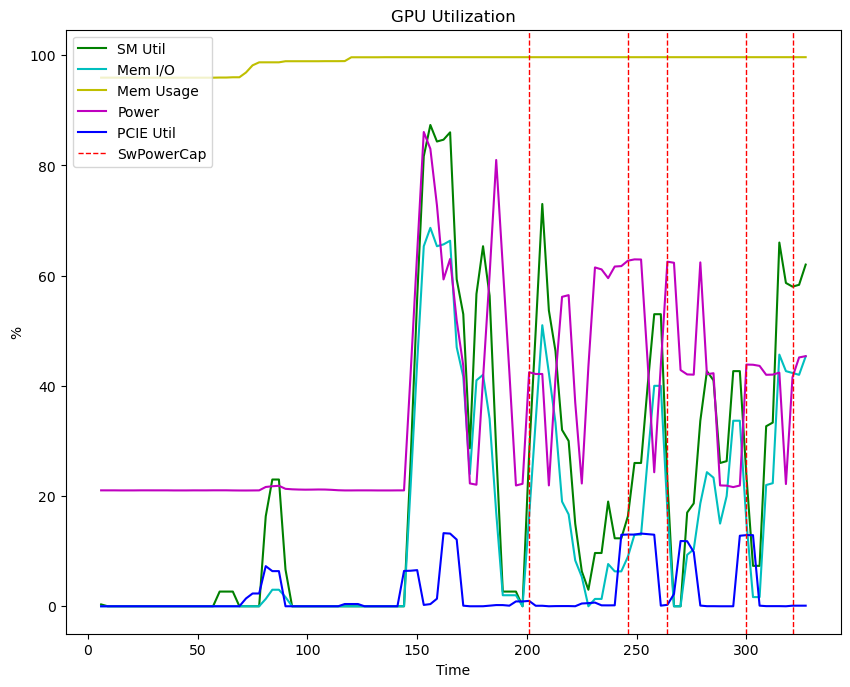

In [6]:
print("Start training...\n(this might take a while with tf.distribute)\n")

with strategy.scope():
    train_start = time.time()
    model.fit(train, steps_per_epoch=train_steps,
              epochs=epochs, callbacks=callbacks, verbose=verbose)
    train_end = time.time()
    
print("\nTraining took", int(train_end-train_start), "seconds")
duration = min(time_callback.times)
slow_fps = train_steps*BATCH_SIZE/duration
print("\nImages per second")
print("*", replicas, "GPU:", int(slow_fps))
print("* Per GPU:", int(slow_fps/replicas))

print("GPU Utilization")
nv_stats_recorder = nv_stats.recorder
nv_stats_recorder.plot_gpu_util(smooth=3, outpath="slow.png")

In [7]:
slow_gpu_data = nv_stats_recorder.get_data()
trunc_tlen = len(slow_gpu_data["time_history"])//3
slow_mean_compute = np.mean(slow_gpu_data["sm_util_history"][-trunc_tlen:])
slow_mean_pcie = np.mean(slow_gpu_data["pcie_txrx"][-trunc_tlen:])
slow_mean_power = np.mean(slow_gpu_data["pwr_history"][-trunc_tlen:])
print("Summary of GPU utilization (% of max):")
print("Compute (SM) util:", int(slow_mean_compute), "%")
print("    PCIE bw. util:", int(slow_mean_pcie), "%")
print("Power dissipation:", int(slow_mean_power), "%")

Summary of GPU utilization (% of max):
Compute (SM) util: 30 %
    PCIE bw. util: 4 %
Power dissipation: 44 %


# Let's fix it

In [8]:
reset_session()
time.sleep(1)
strategy = tf.distribute.MirroredStrategy()
replicas = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [9]:
options = tf.data.Options()
read_config = tfds.ReadConfig(options=options, interleave_parallel_reads=n_cores)

dataset_name = "imagenet2012"
dataset, info = tfds.load(dataset_name,
                          # don't use built-in decoder
                          read_config=read_config,
                          as_dataset_kwargs={"read_config":read_config},
                          decoders={'image': tfds.decode.SkipDecoding(),},
                          with_info=True,
                          as_supervised=True)

@tf.function
def format_train_example(_image, _label):
    # decode here
    image = tf.io.decode_jpeg(_image, channels=3,
                              fancy_upscaling=False,
                              dct_method="INTEGER_FAST")
    # image augmentation as per last time
    image = tf.image.resize(image, LARGER_IMGSIZE)
    image = tf.image.random_crop(image, CROP_IMGSIZE)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(_label, num_class)
    return image, label

train = dataset["train"]
train.options().experimental_threading.private_threadpool_size = n_cores
train = train.shuffle(16384)
train = train.repeat(count=-1)
train = train.map(format_train_example, num_parallel_calls=n_cores)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(50)

print("Running pipeline:")
for batch in train.take(2):
    test_img = batch[0].numpy()
    label = batch[1].numpy()
    print("* Image shape:", test_img.shape)
    print("* Label shape:", label.shape)
    
# let prefetch finish
time.sleep(2)

Running pipeline:
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024, 1000)
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024, 1000)


In [10]:
with strategy.scope():
    model = cnn_models.rn50(IMG_SIZE, num_class, weights=None)
    opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")
    model.compile(loss="categorical_crossentropy",
                  optimizer=opt)

In [11]:
time_callback = utils.TimeHistory()
nv_stats = NVStats(gpu_index=0, interval=3)
callbacks = [time_callback, nv_stats]

Start training...
(this might take a while with tf.distribute)

Train for 100 steps
Epoch 1/4
INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 174 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


100/100 - 121s - loss: 7.0103
Epoch 2/4
100/100 - 22s - loss: 6.6241
Epoch 3/4
100/100 - 22s - loss: 6.2495
Epoch 4/4
100/100 - 22s - loss: 5.8552
GPU Throttle: []

Training took 186 seconds

Images per second
* 4 GPU: 4734
* Per GPU: 1183
GPU Utilization


<Figure size 432x288 with 0 Axes>

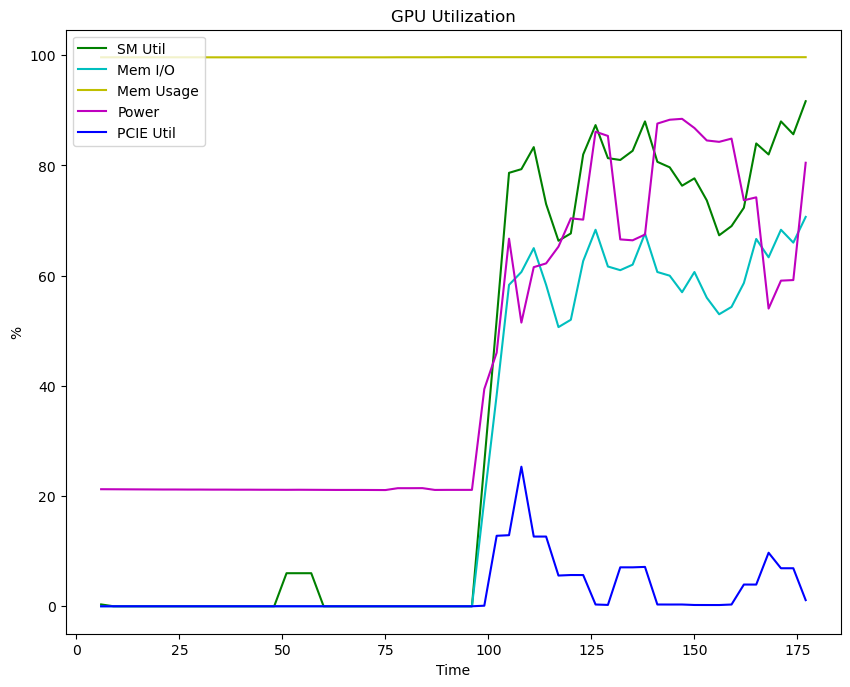

In [12]:
print("Start training...\n(this might take a while with tf.distribute)\n")

with strategy.scope():
    train_start = time.time()
    model.fit(train, steps_per_epoch=train_steps,
              epochs=epochs, callbacks=callbacks, verbose=verbose)
    train_end = time.time()
    
print("\nTraining took", int(train_end-train_start), "seconds")
duration = min(time_callback.times)
fast_fps = train_steps*BATCH_SIZE/duration
print("\nImages per second")
print("*", replicas, "GPU:", int(fast_fps))
print("* Per GPU:", int(fast_fps/replicas))

print("GPU Utilization")
nv_stats_recorder = nv_stats.recorder
nv_stats_recorder.plot_gpu_util(smooth=3, outpath="fast.png")

In [13]:
fast_gpu_data = nv_stats_recorder.get_data()
trunc_tlen = len(fast_gpu_data["time_history"])//3
fast_mean_compute = np.mean(fast_gpu_data["sm_util_history"][-trunc_tlen:])
fast_mean_pcie = np.mean(fast_gpu_data["pcie_txrx"][-trunc_tlen:])
fast_mean_power = np.mean(fast_gpu_data["pwr_history"][-trunc_tlen:])
print("Summary of GPU utilization (% of max):")
print("Compute (SM) util:", int(fast_mean_compute), "%")
print("    PCIE bw. util:", int(fast_mean_pcie), "%")
print("Power dissipation:", int(fast_mean_power), "%")

Summary of GPU utilization (% of max):
Compute (SM) util: 81 %
    PCIE bw. util: 2 %
Power dissipation: 77 %
